In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount = True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/My Drive/LDS8_DeepLearning/LDS8_DinhVietHa_thi/'

/content/gdrive/My Drive/LDS8_DeepLearning/LDS8_DinhVietHa_thi


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import LSTM, Activation, Dense
from tensorflow.keras.layers import Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
%matplotlib inline

In [ ]:
dataset = pd.read_json("./Clothing_Shoes_and_Jewelry_5.json",lines=True)

In [ ]:
dataset.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1KLRMWW2FWPL4,0000031887,"Amazon Customer ""cameramom""","[0, 0]",This is a great tutu and at a really great pri...,5,Great tutu- not cheaply made,1297468800,"02 12, 2011"
1,A2G5TCU2WDFZ65,0000031887,Amazon Customer,"[0, 0]",I bought this for my 4 yr old daughter for dan...,5,Very Cute!!,1358553600,"01 19, 2013"
2,A1RLQXYNCMWRWN,0000031887,Carola,"[0, 0]",What can I say... my daughters have it in oran...,5,I have buy more than one,1357257600,"01 4, 2013"
3,A8U3FAMSJVHS5,0000031887,Caromcg,"[0, 0]","We bought several tutus at once, and they are ...",5,"Adorable, Sturdy",1398556800,"04 27, 2014"
4,A3GEOILWLK86XM,0000031887,CJ,"[0, 0]",Thank you Halo Heaven great product for Little...,5,Grammy's Angels Love it,1394841600,"03 15, 2014"


In [ ]:
dataset.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

Predict **overall** from **reviewText**

In [ ]:
df = dataset[['reviewText','overall']]
df.head()

,reviewText,overall
0,This is a great tutu and at a really great pri...,5
1,I bought this for my 4 yr old daughter for dan...,5
2,What can I say... my daughters have it in oran...,5
3,"We bought several tutus at once, and they are ...",5
4,Thank you Halo Heaven great product for Little...,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278677 entries, 0 to 278676
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   reviewText  278677 non-null  object
 1   overall     278677 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


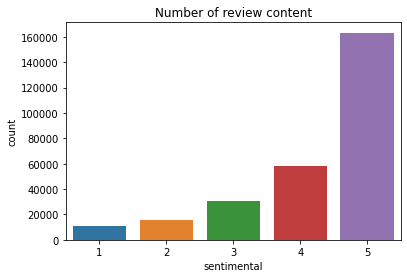

In [ ]:
sns.countplot(df.overall)
plt.xlabel('sentimental')
plt.title('Number of review content')
plt.show()

The 5 stars review accounts for most reviews in the dataset, outnumbered other ratings.

customer sentiment (like: 4 or 5 stars, dislike: 1 or 2 stars, neutral :3 stars) 

In [ ]:
df['overall_new'] = df['overall']

4,5 --> 0 like;
1,2 --> 1 dislike;
3 --> 2 neutral

In [ ]:
df['overall_new'] = df['overall_new'].replace([4,5],0)
df['overall_new'] = df['overall_new'].replace([1,2],1)
df['overall_new'] = df['overall_new'].replace([3],2)

In [ ]:
df_new = df[['reviewText', 'overall_new']]
df_new.head()

,reviewText,overall_new
0,This is a great tutu and at a really great pri...,0
1,I bought this for my 4 yr old daughter for dan...,0
2,What can I say... my daughters have it in oran...,0
3,"We bought several tutus at once, and they are ...",0
4,Thank you Halo Heaven great product for Little...,0


In [ ]:
X = df_new.reviewText
Y = df_new.overall_new

In [ ]:
Y.unique() 

array([0, 2, 1])

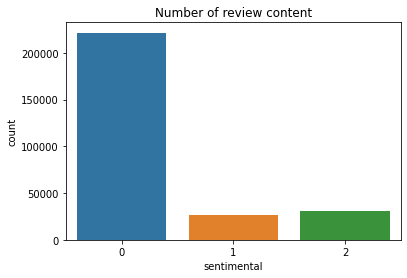

In [ ]:
sns.countplot(df_new.overall_new)
plt.xlabel('sentimental')
plt.title('Number of review content')
plt.show()

The like sentiment (4 and 5 stars - class 0) is 3 times more than the others (neutral and dislike).
--> Customers were satisfied with the products.

In [ ]:
#encoder = LabelEncoder()
#encoder.fit(Y)
#Y = encoder.transform(Y)

In [ ]:
Y[:5]

0    0
1    0
2    0
3    0
4    0
Name: overall_new, dtype: int64

In [ ]:
from keras.utils import to_categorical
Y = to_categorical(Y)
Y[:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3)

Process the data

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
print(sequences[:2])
print(sequences_matrix[:2])

[[2, 19, 445, 15, 36, 356, 5, 215, 85, 16, 224, 784, 3, 334, 33, 18, 12, 464, 114, 174, 259, 26, 37], [2, 25, 15, 2, 77, 4, 348, 29, 247, 28, 163, 9, 1, 238, 56, 288, 2, 197, 52, 128, 305, 187, 4, 29, 273, 206, 130, 205, 4, 284, 2, 226, 331, 32, 15, 13, 30, 192, 4, 59, 381, 8, 85, 725, 15, 46, 122, 48, 107, 13, 102, 448, 23, 40, 1, 50, 14, 136, 445, 813, 12, 101, 138, 28, 204, 50, 62, 218, 12, 34, 28, 12, 593, 17, 14, 23, 40, 90, 246, 7, 1, 308, 9, 16, 14, 4, 59, 47, 55, 331, 28, 42, 13, 67, 4, 99, 32, 47, 490, 15, 13, 14, 24, 40, 2, 81, 28, 1, 175, 547, 5, 12, 465, 13, 3, 14, 43, 210, 5, 258, 30, 24, 392, 64, 1, 593, 84, 3, 13, 14, 20, 229, 2, 516, 2, 150, 5, 125, 372, 88, 677, 2, 235, 230, 5, 19, 10, 267, 2, 200, 218, 601, 462, 243, 8, 243, 15, 14, 13, 194, 116, 22, 50, 148, 85, 4, 23, 17, 180, 71, 983, 446, 294, 18, 50, 218, 340, 8, 446, 101]]
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  

In [ ]:
def RNN():
  inputs = Input(name='inputs', shape=[max_len])
  layer = Embedding(max_words,50,input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  layer = Dense(256,name='FC1')(layer)
  layer = Activation('relu')(layer)
  layer = Dropout(0.5)(layer)
  layer = Dense(3,name='out_layer')(layer)
  layer = Activation('softmax')(layer)
  model = Model(inputs=inputs, outputs=layer)
  return model

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(),
              metrics=['accuracy'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 3)                

In [ ]:
model.fit(sequences_matrix, Y_train,
          batch_size=128,
          epochs=10,
          validation_split=0.2,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0.0001)])

Epoch 1/10
1220/1220 [==============================] - 224s 184ms/step - loss: 0.2734 - accuracy: 0.8242 - val_loss: 0.2465 - val_accuracy: 0.8383
Epoch 2/10
1220/1220 [==============================] - 226s 185ms/step - loss: 0.2370 - accuracy: 0.8445 - val_loss: 0.2321 - val_accuracy: 0.8469
Epoch 3/10
1220/1220 [==============================] - 224s 184ms/step - loss: 0.2227 - accuracy: 0.8539 - val_loss: 0.2210 - val_accuracy: 0.8543
Epoch 4/10
1220/1220 [==============================] - 225s 184ms/step - loss: 0.2154 - accuracy: 0.8574 - val_loss: 0.2353 - val_accuracy: 0.8491


In [ ]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix, Y_test)

2613/2613 [==============================] - 49s 19ms/step - loss: 0.2405 - accuracy: 0.8447


In [ ]:
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

Test set
 Loss: 0.241
 Accuracy: 0.845
